In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset
from training import *
from data_statistics import *

from GNN_TrackLinkingNet import GNN_TrackLinkingNet, FocalLoss, weight_init

from IPython.display import display

2025-05-14 16:24:01.361970: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 16:24:01.383239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747232641.407406     656 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747232641.414587     656 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 16:24:01.440879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo_new/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [4]:
print_dataset_statistics(dataset_training)

Number of events in training dataset: 299


/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

Number of nodes: 8710
Mean Number of nodes: 29.130434782608695
Number of edges: 53836
Mean Number of edges: 180.05351170568562
Number of positive edges: 47377
Mean Number of positive edges: 158.45150756835938
Number of negative edges: 6459
Mean Number of negative edges: 21.602006912231445


In [5]:
print_dataset_statistics(dataset_test)

Number of events in training dataset: 100
Number of nodes: 2891
Mean Number of nodes: 28.91
Number of edges: 17805
Mean Number of edges: 178.05
Number of positive edges: 15627
Mean Number of positive edges: 156.27000427246094
Number of negative edges: 2178
Mean Number of negative edges: 21.780000686645508


In [6]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [9]:
epochs = 200
start_epoch = 0

model = GNN_TrackLinkingNet(input_dim = dataset_training.get(0).x.shape[1], 
                                edge_feature_dim=dataset_training.get(0).edges_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True)
                               #dropout=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
loss_obj = FocalLoss(alpha=0.45, gamma=2)

model.apply(weight_init)

# weights = torch.load(model_folder + "/model_epoch_100_loss_26.8352_2025-05-13.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)


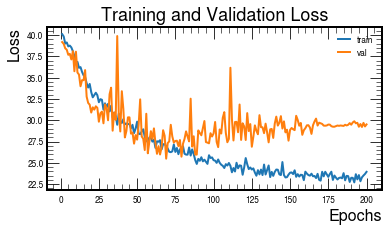

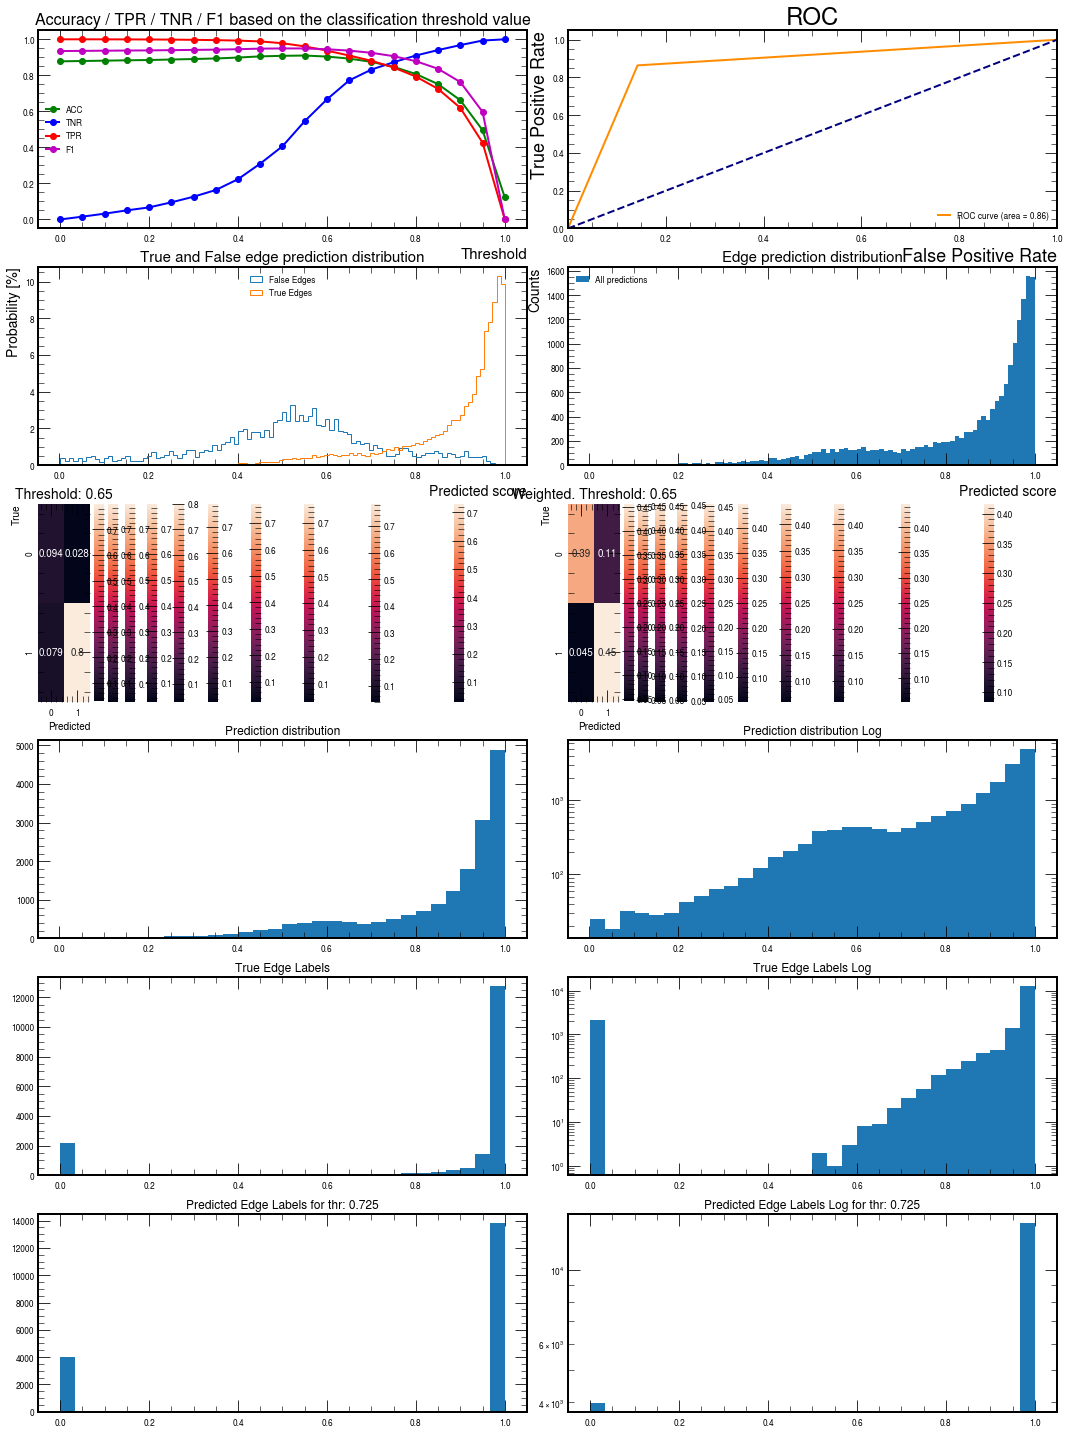

Epoch: 1


Training epoch 1: 100%|██████████| 299/299 [00:05<00:00, 56.02it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 79.44it/s]


Epoch: 2


Training epoch 2: 100%|██████████| 299/299 [00:05<00:00, 54.70it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 86.67it/s]


Epoch: 3


Training epoch 3: 100%|██████████| 299/299 [00:05<00:00, 54.37it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.90it/s]


Epoch: 4


Training epoch 4: 100%|██████████| 299/299 [00:05<00:00, 55.16it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 120.45it/s]


Epoch: 5


Training epoch 5: 100%|██████████| 299/299 [00:04<00:00, 63.40it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.94it/s]


Epoch: 6


Training epoch 6: 100%|██████████| 299/299 [00:04<00:00, 65.53it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 115.80it/s]


Epoch: 7


Training epoch 7: 100%|██████████| 299/299 [00:04<00:00, 64.08it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.59it/s]


Epoch: 8


Training epoch 8: 100%|██████████| 299/299 [00:04<00:00, 64.38it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.73it/s]


Epoch: 9


Training epoch 9: 100%|██████████| 299/299 [00:04<00:00, 64.16it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.91it/s]


Epoch: 10


Training epoch 10: 100%|██████████| 299/299 [00:04<00:00, 62.37it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.77it/s]


Epoch: 11


Training epoch 11: 100%|██████████| 299/299 [00:04<00:00, 62.99it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 117.52it/s]


Epoch: 12


Training epoch 12: 100%|██████████| 299/299 [00:04<00:00, 63.58it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.32it/s]


Epoch: 13


Training epoch 13: 100%|██████████| 299/299 [00:04<00:00, 62.90it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.46it/s]


Epoch: 14


Training epoch 14: 100%|██████████| 299/299 [00:04<00:00, 62.30it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.69it/s]


Epoch: 15


Training epoch 15: 100%|██████████| 299/299 [00:04<00:00, 62.80it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.33it/s]


Epoch: 16


Training epoch 16: 100%|██████████| 299/299 [00:04<00:00, 61.81it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.42it/s]


Epoch: 17


Training epoch 17: 100%|██████████| 299/299 [00:04<00:00, 63.17it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.06it/s]


Epoch: 18


Training epoch 18: 100%|██████████| 299/299 [00:04<00:00, 64.39it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.99it/s]


Epoch: 19


Training epoch 19: 100%|██████████| 299/299 [00:05<00:00, 55.23it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.94it/s]


Epoch: 20


Training epoch 20: 100%|██████████| 299/299 [00:04<00:00, 60.93it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.26it/s]


Epoch: 20
F1 score: 0.869
Balanced Accuracy: 0.801
Accuracy: 0.792
Precision: 96.8190
Recall: 78.8827
Negative predictive value: 34.9497
True negative rate: 81.4050
[0.79402231 0.80923808] [0.81404959 0.78882703] [0.80391124 0.79890221]
Precision Weighted: [0.79402231 0.80923808]
Recall Weighted: [0.81404959 0.78882703]
F1 score Weighted: [0.80391124 0.79890221]
positive_likelihood_ratio: 4.242136473198097, negative_likelihood_ratio: 0.25941045028469856
Epoch: 21


Training epoch 21:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.89it/s]


Epoch: 22


Training epoch 22: 100%|██████████| 299/299 [00:04<00:00, 62.14it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.61it/s]


Epoch: 23


Training epoch 23: 100%|██████████| 299/299 [00:04<00:00, 63.05it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.73it/s]


Epoch: 24


Training epoch 24: 100%|██████████| 299/299 [00:04<00:00, 60.23it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 101.50it/s]


Epoch: 25


Training epoch 25: 100%|██████████| 299/299 [00:04<00:00, 62.76it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.21it/s]


Epoch: 26


Training epoch 26: 100%|██████████| 299/299 [00:04<00:00, 60.02it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.05it/s]


Epoch: 27


Training epoch 27: 100%|██████████| 299/299 [00:04<00:00, 61.28it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 86.43it/s]


Epoch: 28


Training epoch 28: 100%|██████████| 299/299 [00:05<00:00, 58.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.64it/s]


Epoch: 29


Training epoch 29: 100%|██████████| 299/299 [00:04<00:00, 64.16it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.30it/s]


Epoch: 30


Training epoch 30: 100%|██████████| 299/299 [00:04<00:00, 61.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.08it/s]


Epoch: 31


Training epoch 31: 100%|██████████| 299/299 [00:04<00:00, 62.67it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.17it/s]


Epoch: 32


Training epoch 32: 100%|██████████| 299/299 [00:04<00:00, 60.82it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.33it/s]


Epoch: 33


Training epoch 33: 100%|██████████| 299/299 [00:04<00:00, 59.88it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.92it/s]


Epoch: 34


Training epoch 34: 100%|██████████| 299/299 [00:04<00:00, 60.13it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 101.73it/s]


Epoch: 35


Training epoch 35: 100%|██████████| 299/299 [00:04<00:00, 61.70it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.87it/s]


Epoch: 36


Training epoch 36: 100%|██████████| 299/299 [00:04<00:00, 61.66it/s]


Validation step


Training epoch 51: 100%|██████████| 299/299 [00:04<00:00, 60.70it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.49it/s]


Epoch: 52


Training epoch 52: 100%|██████████| 299/299 [00:04<00:00, 62.29it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.31it/s]


Epoch: 53


Training epoch 53: 100%|██████████| 299/299 [00:04<00:00, 62.99it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 82.85it/s]


Epoch: 54


Training epoch 54: 100%|██████████| 299/299 [00:05<00:00, 53.18it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 88.13it/s]


Epoch: 55


Training epoch 55: 100%|██████████| 299/299 [00:04<00:00, 60.49it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.39it/s]


Epoch: 56


Training epoch 56: 100%|██████████| 299/299 [00:05<00:00, 54.92it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.81it/s]


Epoch: 57


Training epoch 57: 100%|██████████| 299/299 [00:05<00:00, 54.99it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.25it/s]


Epoch: 58


Training epoch 58: 100%|██████████| 299/299 [00:05<00:00, 59.19it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.05it/s]


Epoch: 59


Training epoch 59: 100%|██████████| 299/299 [00:05<00:00, 59.57it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.15it/s]


Epoch: 60


Training epoch 60: 100%|██████████| 299/299 [00:04<00:00, 61.76it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.44it/s]


Epoch: 60
F1 score: 0.897
Balanced Accuracy: 0.831
Accuracy: 0.832
Precision: 97.2181
Recall: 83.1894
Negative predictive value: 40.7399
True negative rate: 82.9201
[0.83143968 0.82965973] [0.8292011  0.83189352] [0.83031888 0.83077512]
Precision Weighted: [0.83143968 0.82965973]
Recall Weighted: [0.8292011  0.83189352]
F1 score Weighted: [0.83031888 0.83077512]
positive_likelihood_ratio: 4.870602369348337, negative_likelihood_ratio: 0.202733066778748
>>> Saving model to /eos/user/c/czeh/model/epoch_60_date_2025-05-14_loss_27.4852.pt
Epoch: 61


Training epoch 61:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 95.43it/s]


Epoch: 62


Training epoch 62: 100%|██████████| 299/299 [00:05<00:00, 59.44it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.87it/s]


Epoch: 63


Training epoch 63: 100%|██████████| 299/299 [00:05<00:00, 55.84it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.99it/s]


Epoch: 64


Training epoch 64: 100%|██████████| 299/299 [00:04<00:00, 62.06it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.73it/s]


Epoch: 65


Training epoch 65: 100%|██████████| 299/299 [00:04<00:00, 60.79it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.01it/s]


Epoch: 66


Training epoch 66: 100%|██████████| 299/299 [00:04<00:00, 60.92it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.81it/s]


Epoch: 67


Training epoch 67: 100%|██████████| 299/299 [00:04<00:00, 63.01it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.04it/s]


Epoch: 68


Training epoch 68: 100%|██████████| 299/299 [00:04<00:00, 60.99it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.23it/s]


Epoch: 69


Training epoch 69: 100%|██████████| 299/299 [00:04<00:00, 60.96it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.93it/s]


Epoch: 70


Training epoch 70: 100%|██████████| 299/299 [00:05<00:00, 54.67it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.23it/s]


Epoch: 71


Training epoch 71: 100%|██████████| 299/299 [00:05<00:00, 53.05it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 86.28it/s]


Epoch: 72


Training epoch 72: 100%|██████████| 299/299 [00:05<00:00, 53.32it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 81.20it/s]


Epoch: 73


Training epoch 73: 100%|██████████| 299/299 [00:04<00:00, 62.12it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.20it/s]


Epoch: 74


Training epoch 74: 100%|██████████| 299/299 [00:04<00:00, 60.09it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.28it/s]


Epoch: 75


Training epoch 75: 100%|██████████| 299/299 [00:05<00:00, 59.61it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.11it/s]


Epoch: 76


Training epoch 76: 100%|██████████| 299/299 [00:04<00:00, 60.52it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 101.80it/s]


Epoch: 77


Training epoch 77: 100%|██████████| 299/299 [00:05<00:00, 58.63it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.41it/s]


Epoch: 78


Training epoch 78: 100%|██████████| 299/299 [00:05<00:00, 58.81it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.23it/s]


Epoch: 79


Training epoch 79: 100%|██████████| 299/299 [00:04<00:00, 62.49it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.67it/s]


Epoch: 80


Training epoch 80: 100%|██████████| 299/299 [00:04<00:00, 63.00it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.08it/s]


Epoch: 80
F1 score: 0.911
Balanced Accuracy: 0.847
Accuracy: 0.853
Precision: 97.4269
Recall: 85.5315
Negative predictive value: 44.6647
True negative rate: 83.7925
[0.85275394 0.84069499] [0.8379247  0.85531452] [0.84527428 0.84794174]
Precision Weighted: [0.85275394 0.84069499]
Recall Weighted: [0.8379247  0.85531452]
F1 score Weighted: [0.84527428 0.84794174]
positive_likelihood_ratio: 5.277266356931809, negative_likelihood_ratio: 0.17267121972771046
Epoch: 81


Training epoch 81:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.30it/s]


Epoch: 82


Training epoch 82: 100%|██████████| 299/299 [00:04<00:00, 62.96it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.06it/s]


Epoch: 83


Training epoch 83: 100%|██████████| 299/299 [00:04<00:00, 60.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.35it/s]


Epoch: 84


Training epoch 84: 100%|██████████| 299/299 [00:05<00:00, 58.38it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 100.33it/s]


Epoch: 85


Training epoch 85: 100%|██████████| 299/299 [00:05<00:00, 59.38it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.91it/s]


Epoch: 86


Training epoch 86: 100%|██████████| 299/299 [00:05<00:00, 55.43it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 92.56it/s]


Epoch: 87


Training epoch 87: 100%|██████████| 299/299 [00:05<00:00, 55.36it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 92.52it/s]


Epoch: 88


Training epoch 88: 100%|██████████| 299/299 [00:05<00:00, 57.35it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.23it/s]


Epoch: 89


Training epoch 89: 100%|██████████| 299/299 [00:04<00:00, 61.47it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.33it/s]


Epoch: 90


Training epoch 90: 100%|██████████| 299/299 [00:04<00:00, 64.29it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.57it/s]


Epoch: 91


Training epoch 91: 100%|██████████| 299/299 [00:04<00:00, 65.37it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.95it/s]


Epoch: 92


Training epoch 92: 100%|██████████| 299/299 [00:04<00:00, 63.58it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.49it/s]


Epoch: 93


Training epoch 93: 100%|██████████| 299/299 [00:04<00:00, 62.91it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.58it/s]


Epoch: 94


Training epoch 94: 100%|██████████| 299/299 [00:05<00:00, 53.14it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.26it/s]


Epoch: 95


Training epoch 95: 100%|██████████| 299/299 [00:05<00:00, 54.20it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.48it/s]


Epoch: 96


Training epoch 96: 100%|██████████| 299/299 [00:05<00:00, 54.25it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 82.80it/s]


Epoch: 97


Training epoch 97: 100%|██████████| 299/299 [00:04<00:00, 61.43it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 116.46it/s]


Epoch: 98


Training epoch 98: 100%|██████████| 299/299 [00:04<00:00, 63.27it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.50it/s]


Epoch: 99


Training epoch 99: 100%|██████████| 299/299 [00:04<00:00, 63.36it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.04it/s]


Epoch: 100


Training epoch 100: 100%|██████████| 299/299 [00:04<00:00, 65.13it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 116.80it/s]


Epoch: 100
F1 score: 0.906
Balanced Accuracy: 0.856
Accuracy: 0.847
Precision: 97.8491
Recall: 84.4244
Negative predictive value: 43.6835
True negative rate: 86.6850
[0.84768718 0.86377067] [0.86685032 0.84424394] [0.85716166 0.85389568]
Precision Weighted: [0.84768718 0.86377067]
Recall Weighted: [0.86685032 0.84424394]
F1 score Weighted: [0.85716166 0.85389568]
positive_likelihood_ratio: 6.340563083787345, negative_likelihood_ratio: 0.179680458528427
Epoch: 101


Training epoch 101:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.59it/s]


Epoch: 102


Training epoch 102: 100%|██████████| 299/299 [00:04<00:00, 62.20it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.87it/s]


Epoch: 103


Training epoch 103: 100%|██████████| 299/299 [00:04<00:00, 63.06it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.62it/s]


Epoch: 104


Training epoch 104: 100%|██████████| 299/299 [00:04<00:00, 64.02it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.85it/s]


Epoch: 105


Training epoch 105: 100%|██████████| 299/299 [00:04<00:00, 60.14it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.74it/s]


Epoch: 106


Training epoch 106: 100%|██████████| 299/299 [00:05<00:00, 55.58it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 101.09it/s]


Epoch: 107


Training epoch 107: 100%|██████████| 299/299 [00:05<00:00, 58.29it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.62it/s]


Epoch: 108


Training epoch 108: 100%|██████████| 299/299 [00:05<00:00, 57.58it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.54it/s]


Epoch: 109


Training epoch 109: 100%|██████████| 299/299 [00:05<00:00, 57.07it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.77it/s]


Epoch: 110


Training epoch 110: 100%|██████████| 299/299 [00:04<00:00, 61.57it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.57it/s]


Epoch: 111


Training epoch 111: 100%|██████████| 299/299 [00:04<00:00, 60.46it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.18it/s]


Epoch: 112


Training epoch 112: 100%|██████████| 299/299 [00:05<00:00, 57.22it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 116.80it/s]


Epoch: 113


Training epoch 113: 100%|██████████| 299/299 [00:04<00:00, 62.17it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.05it/s]


Epoch: 114


Training epoch 114: 100%|██████████| 299/299 [00:04<00:00, 61.17it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.77it/s]


Epoch: 115


Training epoch 115: 100%|██████████| 299/299 [00:04<00:00, 60.28it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.68it/s]


Epoch: 116


Training epoch 116: 100%|██████████| 299/299 [00:05<00:00, 59.77it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 61.51it/s]


Epoch: 117


Training epoch 117: 100%|██████████| 299/299 [00:05<00:00, 54.64it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.91it/s]


Epoch: 118


Training epoch 118: 100%|██████████| 299/299 [00:04<00:00, 62.63it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 94.15it/s]


Epoch: 119


Training epoch 119: 100%|██████████| 299/299 [00:05<00:00, 52.42it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.97it/s]


Epoch: 120


Training epoch 120: 100%|██████████| 299/299 [00:05<00:00, 53.17it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 82.13it/s]


Epoch: 120
F1 score: 0.916
Balanced Accuracy: 0.853
Accuracy: 0.861
Precision: 97.5273
Recall: 86.3186
Negative predictive value: 46.2003
True negative rate: 84.2975
[0.86036341 0.84608586] [0.84297521 0.86318551] [0.85158056 0.85455015]
Precision Weighted: [0.86036341 0.84608586]
Recall Weighted: [0.84297521 0.86318551]
F1 score Weighted: [0.85158056 0.85455015]
positive_likelihood_ratio: 5.497128788567695, negative_likelihood_ratio: 0.162299539384449
>>> Saving model to /eos/user/c/czeh/model/epoch_120_date_2025-05-14_loss_24.4541.pt
Epoch: 121


Training epoch 121:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.44it/s]


Epoch: 122


Training epoch 122: 100%|██████████| 299/299 [00:04<00:00, 62.03it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.52it/s]


Epoch: 123


Training epoch 123: 100%|██████████| 299/299 [00:04<00:00, 60.99it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.45it/s]


Epoch: 124


Training epoch 124: 100%|██████████| 299/299 [00:04<00:00, 61.78it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.38it/s]


Epoch: 125


Training epoch 125: 100%|██████████| 299/299 [00:04<00:00, 62.73it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.88it/s]


Epoch: 126


Training epoch 126: 100%|██████████| 299/299 [00:05<00:00, 52.29it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 83.63it/s]


Epoch: 127


Training epoch 127: 100%|██████████| 299/299 [00:05<00:00, 52.67it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 79.92it/s]


Epoch: 128


Training epoch 128: 100%|██████████| 299/299 [00:05<00:00, 53.13it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 82.71it/s]


Epoch: 129


Training epoch 129: 100%|██████████| 299/299 [00:04<00:00, 62.62it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.85it/s]


Epoch: 130


Training epoch 130: 100%|██████████| 299/299 [00:04<00:00, 63.57it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.79it/s]


Epoch: 131


Training epoch 131: 100%|██████████| 299/299 [00:04<00:00, 64.19it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.23it/s]


Epoch: 132


Training epoch 132: 100%|██████████| 299/299 [00:05<00:00, 53.74it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.52it/s]


Epoch: 133


Training epoch 133: 100%|██████████| 299/299 [00:04<00:00, 61.38it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.64it/s]


Epoch: 134


Training epoch 134: 100%|██████████| 299/299 [00:04<00:00, 63.41it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.16it/s]


Epoch: 135


Training epoch 135: 100%|██████████| 299/299 [00:04<00:00, 63.40it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.45it/s]


Epoch: 136


Training epoch 136: 100%|██████████| 299/299 [00:04<00:00, 61.90it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.34it/s]


Epoch: 137


Training epoch 137: 100%|██████████| 299/299 [00:05<00:00, 59.66it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.21it/s]


Epoch: 138


Training epoch 138: 100%|██████████| 299/299 [00:04<00:00, 60.43it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 83.08it/s]


Epoch: 139


Training epoch 139: 100%|██████████| 299/299 [00:05<00:00, 53.93it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 75.00it/s]


Epoch: 140


Training epoch 140: 100%|██████████| 299/299 [00:05<00:00, 52.65it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.28it/s]


Epoch: 140
F1 score: 0.914
Balanced Accuracy: 0.857
Accuracy: 0.858
Precision: 97.7061
Recall: 85.8578
Negative predictive value: 45.7402
True negative rate: 85.5372
[0.85812322 0.85583413] [0.8553719 0.8585781] [0.85674535 0.85720392]
Precision Weighted: [0.85812322 0.85583413]
Recall Weighted: [0.8553719 0.8585781]
F1 score Weighted: [0.85674535 0.85720392]
positive_likelihood_ratio: 5.936454305277496, negative_likelihood_ratio: 0.1653338131173316
Epoch: 141


Training epoch 141:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.47it/s]


Epoch: 142


Training epoch 142: 100%|██████████| 299/299 [00:04<00:00, 63.43it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.86it/s]


Epoch: 143


Training epoch 143: 100%|██████████| 299/299 [00:05<00:00, 57.90it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.22it/s]


Epoch: 144


Training epoch 144: 100%|██████████| 299/299 [00:04<00:00, 60.25it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.35it/s]


Epoch: 145


Training epoch 145: 100%|██████████| 299/299 [00:05<00:00, 59.67it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.04it/s]


Epoch: 146


Training epoch 146: 100%|██████████| 299/299 [00:05<00:00, 58.46it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.95it/s]


Epoch: 147


Training epoch 147: 100%|██████████| 299/299 [00:05<00:00, 58.87it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.18it/s]


Epoch: 148


Training epoch 148: 100%|██████████| 299/299 [00:05<00:00, 59.20it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.51it/s]


Epoch: 149


Training epoch 149: 100%|██████████| 299/299 [00:04<00:00, 62.09it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.52it/s]


Epoch: 150


Training epoch 150: 100%|██████████| 299/299 [00:05<00:00, 55.65it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 82.02it/s]


Epoch: 151


Training epoch 151: 100%|██████████| 299/299 [00:05<00:00, 51.91it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 82.60it/s]


Epoch: 152


Training epoch 152: 100%|██████████| 299/299 [00:05<00:00, 51.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.81it/s]


Epoch: 153


Training epoch 153: 100%|██████████| 299/299 [00:05<00:00, 58.64it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.31it/s]


Epoch: 154


Training epoch 154: 100%|██████████| 299/299 [00:05<00:00, 59.02it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.88it/s]


Epoch: 155


Training epoch 155: 100%|██████████| 299/299 [00:04<00:00, 60.07it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.41it/s]


Epoch: 156


Training epoch 156: 100%|██████████| 299/299 [00:04<00:00, 62.14it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.42it/s]


Epoch: 157


Training epoch 157: 100%|██████████| 299/299 [00:05<00:00, 59.77it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.97it/s]


Epoch: 158


Training epoch 158: 100%|██████████| 299/299 [00:05<00:00, 56.98it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 117.31it/s]


Epoch: 159


Training epoch 159: 100%|██████████| 299/299 [00:05<00:00, 59.51it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 97.87it/s]


Epoch: 160


Training epoch 160: 100%|██████████| 299/299 [00:05<00:00, 59.43it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.33it/s]


Epoch: 160
F1 score: 0.916
Balanced Accuracy: 0.860
Accuracy: 0.861
Precision: 97.7765
Recall: 86.1074
Negative predictive value: 46.3023
True negative rate: 85.9504
[0.86085537 0.85972432] [0.85950413 0.86107378] [0.86017922 0.86039852]
Precision Weighted: [0.86085537 0.85972432]
Recall Weighted: [0.85950413 0.86107378]
F1 score Weighted: [0.86017922 0.86039852]
positive_likelihood_ratio: 6.128819275838575, negative_likelihood_ratio: 0.16163531068023293
Epoch: 161


Training epoch 161:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.38it/s]


Epoch: 162


Training epoch 162: 100%|██████████| 299/299 [00:04<00:00, 64.14it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.38it/s]


Epoch: 163


Training epoch 163: 100%|██████████| 299/299 [00:04<00:00, 62.53it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 119.40it/s]


Epoch: 164


Training epoch 164: 100%|██████████| 299/299 [00:04<00:00, 63.95it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.53it/s]


Epoch: 165


Training epoch 165: 100%|██████████| 299/299 [00:04<00:00, 62.41it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.48it/s]


Epoch: 166


Training epoch 166: 100%|██████████| 299/299 [00:05<00:00, 59.76it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.18it/s]


Epoch: 167


Training epoch 167: 100%|██████████| 299/299 [00:05<00:00, 56.13it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.38it/s]


Epoch: 168


Training epoch 168: 100%|██████████| 299/299 [00:05<00:00, 58.09it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.08it/s]


Epoch: 169


Training epoch 169: 100%|██████████| 299/299 [00:05<00:00, 58.55it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.65it/s]


Epoch: 170


Training epoch 170: 100%|██████████| 299/299 [00:05<00:00, 54.27it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 97.95it/s]


Epoch: 171


Training epoch 171: 100%|██████████| 299/299 [00:04<00:00, 60.29it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.75it/s]


Epoch: 172


Training epoch 172: 100%|██████████| 299/299 [00:05<00:00, 57.88it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.12it/s]


Epoch: 173


Training epoch 173: 100%|██████████| 299/299 [00:05<00:00, 58.46it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.56it/s]


Epoch: 174


Training epoch 174: 100%|██████████| 299/299 [00:04<00:00, 62.53it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 98.74it/s]


Epoch: 175


Training epoch 175: 100%|██████████| 299/299 [00:05<00:00, 57.81it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 98.66it/s]


Epoch: 176


Training epoch 176: 100%|██████████| 299/299 [00:04<00:00, 61.11it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.08it/s]


Epoch: 177


Training epoch 177: 100%|██████████| 299/299 [00:04<00:00, 62.22it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.74it/s]


Epoch: 178


Training epoch 178: 100%|██████████| 299/299 [00:05<00:00, 59.36it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.52it/s]


Epoch: 179


Training epoch 179: 100%|██████████| 299/299 [00:04<00:00, 61.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.42it/s]


Epoch: 180


Training epoch 180: 100%|██████████| 299/299 [00:04<00:00, 60.34it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.89it/s]


Epoch: 180
F1 score: 0.916
Balanced Accuracy: 0.860
Accuracy: 0.862
Precision: 97.7375
Recall: 86.2482
Negative predictive value: 46.4757
True negative rate: 85.6749
[0.86168876 0.85756579] [0.85674931 0.8624816 ] [0.85921194 0.86001667]
Precision Weighted: [0.86168876 0.85756579]
Recall Weighted: [0.85674931 0.8624816 ]
F1 score Weighted: [0.85921194 0.86001667]
positive_likelihood_ratio: 6.0207850318236185, negative_likelihood_ratio: 0.16051182747643672
>>> Saving model to /eos/user/c/czeh/model/epoch_180_date_2025-05-14_loss_23.2542.pt
Epoch: 181


Training epoch 181:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.20it/s]


Epoch: 182


Training epoch 182: 100%|██████████| 299/299 [00:04<00:00, 60.32it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.14it/s]


Epoch: 183


Training epoch 183: 100%|██████████| 299/299 [00:04<00:00, 62.23it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 115.79it/s]


Epoch: 184


Training epoch 184: 100%|██████████| 299/299 [00:04<00:00, 64.58it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.36it/s]


Epoch: 185


Training epoch 185: 100%|██████████| 299/299 [00:04<00:00, 63.87it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.13it/s]


Epoch: 186


Training epoch 186: 100%|██████████| 299/299 [00:04<00:00, 63.40it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.55it/s]


Epoch: 187


Training epoch 187: 100%|██████████| 299/299 [00:04<00:00, 63.24it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 115.26it/s]


Epoch: 188


Training epoch 188: 100%|██████████| 299/299 [00:04<00:00, 62.57it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.41it/s]


Epoch: 189


Training epoch 189: 100%|██████████| 299/299 [00:05<00:00, 51.13it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.02it/s]


Epoch: 190


Training epoch 190: 100%|██████████| 299/299 [00:04<00:00, 64.13it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.27it/s]


Epoch: 191


Training epoch 191: 100%|██████████| 299/299 [00:04<00:00, 61.55it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 68.54it/s]


Epoch: 192


Training epoch 192: 100%|██████████| 299/299 [00:05<00:00, 58.81it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 74.07it/s]


Epoch: 193


Training epoch 193: 100%|██████████| 299/299 [00:05<00:00, 57.57it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.42it/s]


Epoch: 194


Training epoch 194: 100%|██████████| 299/299 [00:04<00:00, 63.39it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.37it/s]


Epoch: 195


Training epoch 195: 100%|██████████| 299/299 [00:05<00:00, 57.20it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 79.33it/s]


Epoch: 196


Training epoch 196: 100%|██████████| 299/299 [00:05<00:00, 51.68it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 76.77it/s]


Epoch: 197


Training epoch 197: 100%|██████████| 299/299 [00:05<00:00, 56.41it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.57it/s]


Epoch: 198


Training epoch 198: 100%|██████████| 299/299 [00:04<00:00, 61.74it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 101.85it/s]


Epoch: 199


Training epoch 199: 100%|██████████| 299/299 [00:04<00:00, 59.95it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 73.46it/s]


Epoch: 200


Training epoch 200: 100%|██████████| 299/299 [00:06<00:00, 48.46it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 72.15it/s]


Epoch: 200
F1 score: 0.917
Balanced Accuracy: 0.861
Accuracy: 0.863
Precision: 97.7559
Recall: 86.4145
Negative predictive value: 46.8053
True negative rate: 85.7668
[0.86325961 0.85858365] [0.85766758 0.86414539] [0.86045451 0.86135554]
Precision Weighted: [0.86325961 0.85858365]
Recall Weighted: [0.85766758 0.86414539]
F1 score Weighted: [0.86045451 0.86135554]
positive_likelihood_ratio: 6.071318251908917, negative_likelihood_ratio: 0.1584000759680063
>>> Saving model to /eos/user/c/czeh/model/epoch_200_date_2025-05-14_loss_23.9350.pt


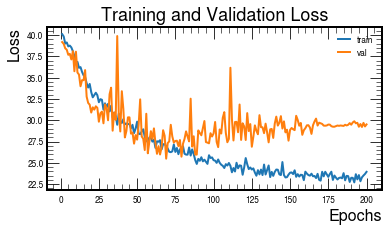

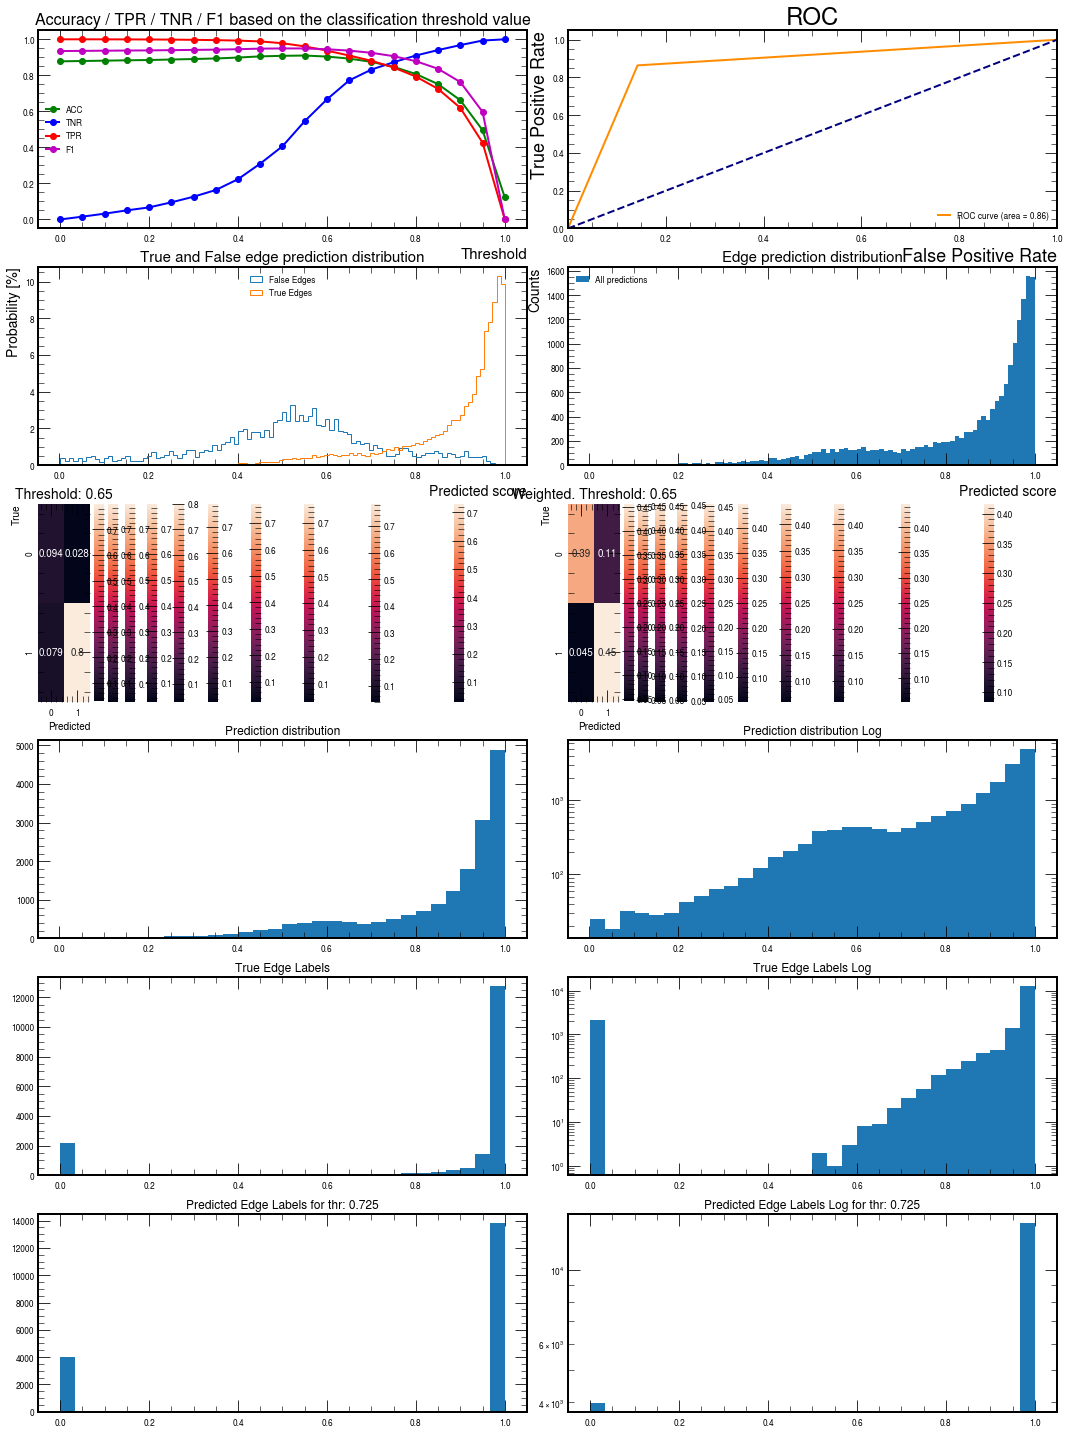

In [11]:
# decision_th = 0.5
os.makedirs(model_folder, exist_ok=True)

train_loss_hist = []
val_loss_hist = []
edge_features = True
date = f"{datetime.now():%Y-%m-%d}"

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

fig_analysis, ax_analysis = plt.subplots(6, 2)
fig_analysis.set_figwidth(15)
fig_analysis.set_figheight(20)
fig_analysis.tight_layout(pad=2.0)

display_loss = display(1, display_id=True)
display_analysis = display(2, display_id=True)

for epoch in range(start_epoch, epochs):
    print(f'Epoch: {epoch+1}')
    
    loss = train(model, optimizer, train_dl, epoch+1, device=device, edge_features=edge_features, loss_obj=loss_obj)
    train_loss_hist.append(loss)
    
    val_loss, pred, y = test(model, test_dl, epoch+1, loss_obj=loss_obj, edge_features=edge_features, device=device)
    
    pred_discrete = (pred > 0.5).astype(int)
    y_discrete = (y > 0).astype(int)
    
    val_loss_hist.append(val_loss)
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss)
    display_loss.update(fig_loss)
    time.sleep(1)
      
    if ((epoch+1)%60==0 or epoch+1==epochs):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
            
        plot_validation_results(pred, y, save=True, ax=ax_analysis, output_folder=model_folder, file_suffix=f"epoch_{epoch+1}_date_{date}")
        display_analysis.update(fig_analysis)
        time.sleep(1)
        
        save_model(model, epoch, optimizer, loss, val_loss, output_folder=model_folder, filename=f"epoch_{epoch+1}_date_{date}_loss_{loss:.4f}.pt")
    elif ((epoch+1)%20==0):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
        plot_validation_results(pred, y, save=False, ax=ax_analysis) 
        display_analysis.update(fig_analysis)
        time.sleep(1)

    scheduler.step() 